## Experiment 2
- ASTER dems
- using processed outputs from ragmac_xdem/scripts/main_experiment2.py
- these dems are all already aligned, but can add check and reproject as needed, e.g. https://github.com/GlacioHack/geoprofile/blob/main/geoprofile/core/core.py#L122

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import xdem
import geoutils as gu
import numpy as np
import datetime
import psutil
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tools

In [3]:
input_dir = '../data/processed/experiment_2/PK_Baltoro/ASTER_DEMs'
dem_fn_list = glob.glob(os.path.join(input_dir, '*.tif'))
dem_fn_list.sort()

In [4]:
len(dem_fn_list)

119

In [5]:
arrays = []
dt_list_decyear = []

for fn in dem_fn_list:
    src = gu.georaster.Raster(fn)  
    arrays.append(src.data)
    decyear = float(os.path.basename(fn).split('_')[1])
    dt_list_decyear.append(decyear)

In [6]:
ma_stack = np.ma.vstack(arrays)

In [8]:
ma_stack.shape

(119, 3176, 3878)

In [7]:
dt_list = [tools.convert_decimal_date_to_date_time(i)[0] for i in dt_list_decyear]

In [9]:
dt_list

[datetime.datetime(2000, 7, 18, 6, 1, 51),
 datetime.datetime(2000, 9, 11, 6, 7, 52),
 datetime.datetime(2001, 3, 6, 6, 4),
 datetime.datetime(2001, 3, 31, 5, 57, 14),
 datetime.datetime(2001, 5, 18, 5, 56, 20),
 datetime.datetime(2001, 8, 29, 5, 59, 54),
 datetime.datetime(2001, 8, 29, 6, 0, 3),
 datetime.datetime(2001, 12, 28, 5, 49, 47),
 datetime.datetime(2002, 4, 26, 5, 54, 18),
 datetime.datetime(2002, 4, 26, 5, 54, 26),
 datetime.datetime(2002, 10, 3, 5, 53, 57),
 datetime.datetime(2002, 10, 3, 5, 54, 4),
 datetime.datetime(2003, 4, 22, 5, 47, 5),
 datetime.datetime(2003, 5, 31, 5, 53, 17),
 datetime.datetime(2003, 9, 20, 5, 52, 27),
 datetime.datetime(2003, 10, 6, 5, 52, 46),
 datetime.datetime(2003, 10, 22, 5, 52, 45),
 datetime.datetime(2003, 10, 22, 5, 52, 55),
 datetime.datetime(2004, 3, 30, 5, 52, 46),
 datetime.datetime(2004, 3, 30, 5, 52, 56),
 datetime.datetime(2004, 8, 14, 5, 46, 14),
 datetime.datetime(2004, 9, 15, 5, 46, 4),
 datetime.datetime(2004, 11, 2, 5, 45, 36)

In [10]:
common_mask = np.ma.getmaskarray(ma_stack).all(axis=0)

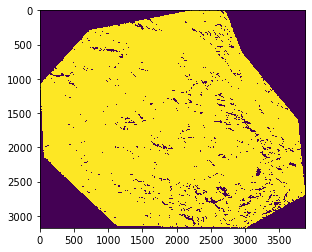

In [11]:
plt.imshow(~common_mask)

### Per-pixel linear regression

github issue: https://github.com/adehecq/ragmac_xdem/issues/8

```
Write a function that takes a stack of DEMs on the same grid (i.e. a 3D masked array) and returns fit parameters of a temporal regression.
Example based on David's code: https://github.com/dshean/pygeotools/blob/9c8d7d5cff5f4fd1c08cf2d46dd1566d229ae9ad/pygeotools/lib/malib.py#L999

Additionally, write a function that takes the fit parameters and returns the elevation of all pixels at any given time within the valid time range.
```


### Prepare test dataset

In [12]:
#ma_stack_test = ma_stack[:, 1000:1032, 1000:1032]
stride = 10
ma_stack_test = ma_stack[:, ::stride, ::stride]

In [13]:
ma_stack_test.shape

(119, 318, 388)

In [25]:
def plot_ma_linreg_3panel(results):
    m, b, m_detr = results
    f, axa = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 3), dpi=150)
    clim_perc = (5, 95)
    _m = axa[0].imshow(m, cmap='RdBu', clim=tools.calcperc_sym(m, clim_perc))
    f.colorbar(_m, ax=axa[0])
    _m = axa[1].imshow(b, cmap='viridis', clim=tools.calcperc(b))
    f.colorbar(_m, ax=axa[1])
    _m = axa[2].imshow(m_detr, cmap='inferno', clim=tools.calcperc(m_detr, (0,95)))
    f.colorbar(_m, ax=axa[2])

    for ax in axa:
        ax.set_xticks(())
        ax.set_yticks(())

In [15]:
def plot_ma_linreg(results):
    m, b, m_detr = results
    f, ax = plt.subplots(dpi=150)
    clim_perc = (5, 95)
    _m = ax.imshow(m, cmap='RdBu', clim=tools.calcperc_sym(m, clim_perc))
    f.colorbar(_m, ax=ax)
    ax.set_xticks(())
    ax.set_yticks(())

In [16]:
%%time
"""
Modifications to malib.ma_linreg transposed to tools.py
# use matplitlib.dates.date2num directly to convert time stamps
# use psutils to check for logical cores
# add aux functions from malib.py 
 - mad()
 - checkma()
"""

results = tools.ma_linreg(ma_stack_test, 
                          dt_list, 
                          n_thresh=3, 
                          model='theilsen', 
                          dt_stack_ptp=None, 
                          min_dt_ptp=None, 
                          smooth=False,
                          rsq=False, 
                          conf_test=False, 
                          parallel=True, 
                          n_cpu=None, 
                          remove_outliers=False)

Excluding pixels with count < 3
1
86204 valid pixels with up to 119 timestamps: 2075906 total valid samples
Running in parallel with 15 processes
Computing residuals
CPU times: user 3.49 s, sys: 475 ms, total: 3.96 s
Wall time: 1min 22s


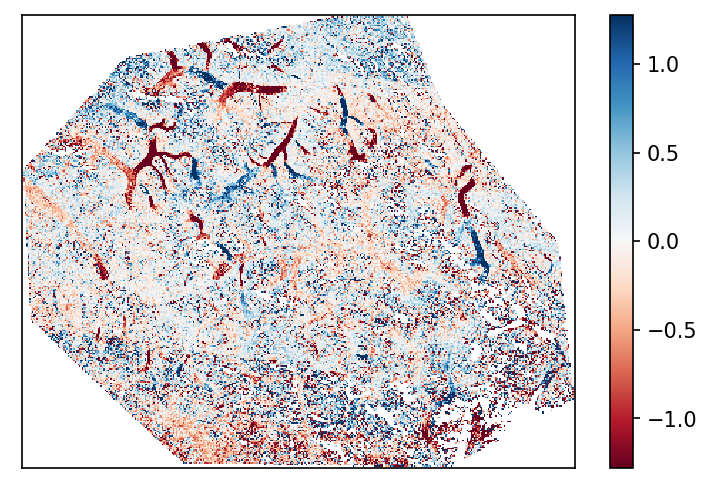

In [17]:
plot_ma_linreg(results)

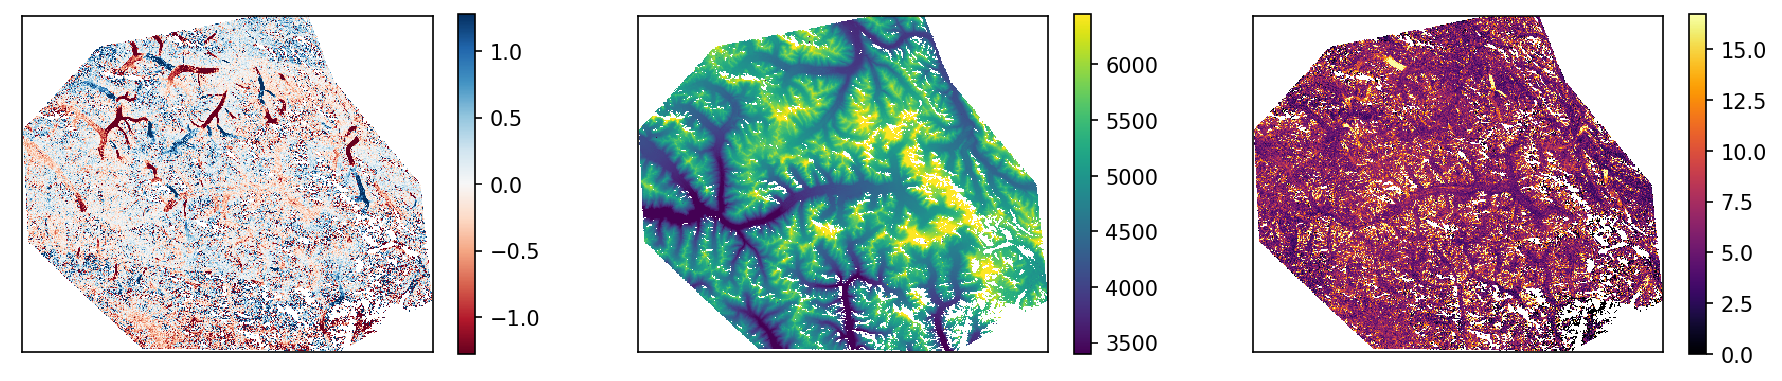

In [26]:
plot_ma_linreg_3panel(results)

## To do
* Filter outliers
* Smoothing
* Add multiprocessing for other robust linear fit appraoches (Romain, Amaury)
* Extrapolate/interpolate to arbitrary dates
* Test for shorter periods between target dates